## General Imports

In [193]:
from sklearn import *
import math
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

import numpy as np
from collections import Counter
import pandas as pd 
import xgboost as xgb
from xgboost import XGBClassifier

import os
import statsmodels.api as sm 

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek


# Function Decleration


In [194]:
def zscore_outliers(x, cutoff=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    dmean = x.mean()
    dsd = x.std()
    rng = dsd * cutoff
    lower = dmean - rng
    upper = dmean + rng
    if return_thresholds:
        return lower, upper
    else:
        return [True if z < lower or z > upper else False for z in x]


def iqr_outliers(x, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25 = np.percentile(x, 25)
    q75 = np.percentile(x, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if z < lower or z > upper else False for z in x]
    
    
def generate_pie_from_df(df, key, title=None, radius=1):
    if title is None:
        title = key
    
    lable_list = []
    data = df.groupby(key).size()
    for label in data.keys().tolist():
        list_percent = round(len(df.loc[df[key] == label]) / len(df) * 100)
        list_item = str(list_percent) + '%' + ' ' + str(label)
        lable_list.append(list_item)  

    plt.title(title)
    
    a = plt.pie(data.tolist(),labels=lable_list, shadow=True, radius=radius)
    
def generate_ols(y, x):
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns
    
def validate_missing_value(df_full, df, col_name):
    col_name_fixed = col_name + "_NA"
    #generate 0 and 1 column
    df[col_name_fixed] = 0
    df.loc[(df[col_name].isnull()), [col_name_fixed]] = 1
    #generate the ols
    X2 = sm.add_constant(df_full)
    model = sm.OLS(df[col_name_fixed], X2.astype(float))
    results  = model.fit()
    df.drop(columns=[col_name_fixed], inplace=True)
    return ((results.pvalues < 0.05).value_counts()[1] / len(results.pvalues)) *100
    
def is_normal_distribution(df):
    np.random.seed(28041990)
    k2, p = stats.normaltest(df)
    print("p = {:g}".format(p))
    return p > 1e-3

def create_missing_column(df, col):
    col_name_miss = col + '_MISSING'
    df[col_name_miss] = 0
    df.loc[(df[col].isnull()), [col_name_miss]] = 1
    df.drop(columns=[col], inplace=True)
    
def encode_quartile(df, col):
    temp_col_name = col + '_tmp'
    df[temp_col_name] = "NA"
    desc = df[col].describe()
    int_25 = desc['25%'].astype(int)
    int_50 = desc['50%'].astype(int)
    int_75 = desc['75%'].astype(int)
    
    df.loc[(df[col] <= int_25), [temp_col_name]] = 'Q1'
    df.loc[(df[col] > int_25) & (df[col] <= int_50), [temp_col_name]] = 'Q2'
    df.loc[(df[col] > int_50) & (df[col] <= int_75), [temp_col_name]] = 'Q3'
    df.loc[(df[col] > int_75) , [temp_col_name]] = 'Q4'
    
    #drop original col
    df.drop(columns=[col], inplace=True)
    #rename the cole to original
    df.rename(index=str, columns={temp_col_name: col}, inplace=True)

    
def feature_importance_table(X, y, cutoff=2):
    #lasso
    print('running Lasso')
    lasso_reg = linear_model.Lasso(alpha=0.1)
    lasso_reg.fit(X,y)
    
    
    #random forest
    print('running RF')
    rnd_reg = RandomForestClassifier()
    rnd_reg.fit(X, y)

    # GXB
    print('running GXB')
    xgb_reg = XGBClassifier()
    xgb_reg.fit(X, y)
    
    #create numpy for return data
    coaf_df = pd.DataFrame(index=X.columns.tolist()) 
    coaf_df["XGB"] = 0
    coaf_df["LASSO"] = 0
    coaf_df["RND_FOREST"] = 0
    
    #store the data
    coaf_df.loc[xgb_reg.feature_importances_ >  0, ['XGB']] = 1
    coaf_df.loc[lasso_reg.coef_ != 0, ['LASSO']] = 1
    coaf_df.loc[rnd_reg.feature_importances_ > 0.005, ['RND_FOREST']] = 1
    coaf_df['SCORE'] = coaf_df.sum(axis=1)
    coaf_df = coaf_df.sort_values(by=['SCORE'], ascending=False) 
    feature_list = coaf_df[coaf_df['SCORE'] >= cutoff].index.tolist()
    return coaf_df, xgb_reg, lasso_reg, rnd_reg, feature_list

def test_logistic_model(y, y_pred):
    results = pd.DataFrame() 
    results["y"] = y
    results["y_pred"] = y_pred
    results['summary'] = (results["y"] ^ results["y_pred"]) ^ 1
    return results['summary'].sum() / len(results) * 100, results

def show_distribution_hist(df, col_name, title, x_lable, y_label, bins=15):
    plt.hist(df[col_name] , edgecolor='k', bins=bins)
    plt.title(title); 
    plt.xlabel(x_lable); 
    plt.ylabel(y_label)

def show_distribution_by_col_value(df, src_col, dest_col, title, x_lable, y_label):
    data = df.groupby(src_col).size()
    for label in data.keys().tolist():
        sns.kdeplot(df.loc[df[src_col] == label, dest_col], label = label)
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.title(title)
    


## Data Import

In [51]:
master_df = pd.read_csv('../data/loans.zip', compression='zip')
print('Size of master_df data', master_df.shape)

Size of master_df data (307511, 122)


## Data exploration


Here we will see the relationships between the various datasets:
![alt text](home_credit.png "Home Credit")

In [52]:
master_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
master_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [54]:
master_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

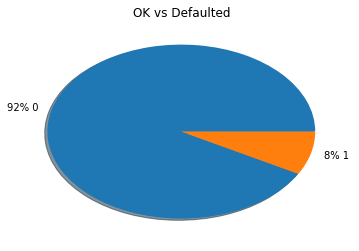

In [55]:
generate_pie_from_df(master_df, 'TARGET', 'OK vs Defaulted')

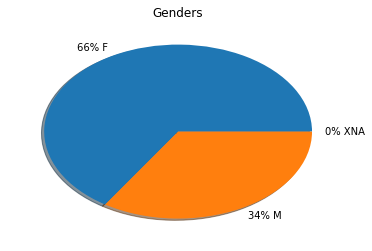

In [56]:
generate_pie_from_df(master_df, 'CODE_GENDER', 'Genders')

change DAYS_BIRTH to positive

In [57]:
master_df['DAYS_BIRTH'] = abs(master_df['DAYS_BIRTH'])

Show distribution by age

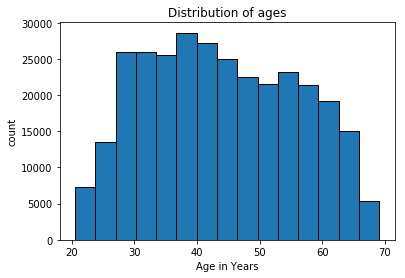

In [58]:
#create a dataset with Days birth  in years
temp = pd.DataFrame()
temp['DAYS_BIRTH'] = master_df['DAYS_BIRTH'] /365
temp['TARGET'] = master_df['TARGET']
#plot
show_distribution_hist(df = temp, col_name = 'DAYS_BIRTH', title='Distribution of ages', x_lable='Age in Years', y_label='count')

Show the distribution of ages by default value

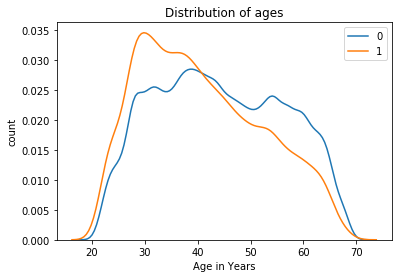

In [59]:
show_distribution_by_col_value(df=temp, src_col='TARGET', 
                               dest_col='DAYS_BIRTH', 
                               title='Distribution of ages', 
                               x_lable='Age in Years', 
                               y_label='count')

Show the distribution of default by age

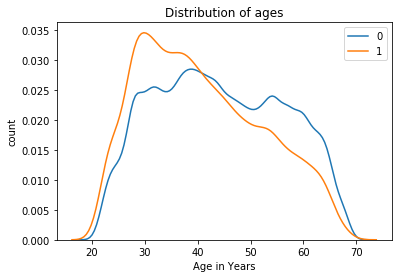

In [60]:
show_distribution_by_col_value(df=days_birth, src_col='TARGET', 
                               dest_col='DAYS_BIRTH', 
                               title='Distribution of ages', 
                               x_lable='Age in Years', 
                               y_label='count')

here we can see that the median age for people that defaulted is lower than those who are not.

Text(0.5,1,'Boxplot by AGE')

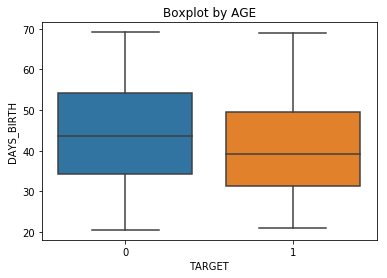

In [61]:

sns.boxplot(y=master_df['DAYS_BIRTH']/365,x=master_df['TARGET']).set_title("Boxplot by AGE" )

lets see the distribution of employment in years

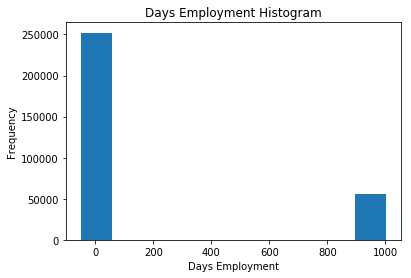

In [62]:
(master_df['DAYS_EMPLOYED'] /365 ).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Clearly there is an outlier because no one works for 1000 years.

Lets see who works over 65 yers

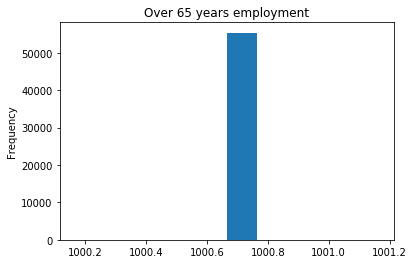

In [63]:

(master_df['DAYS_EMPLOYED'] /365).where(master_df['DAYS_EMPLOYED'] > 65).plot.hist(title = 'Over 65 years employment');

lets describe

In [ ]:
(master_df['DAYS_EMPLOYED'] /365).where(master_df['DAYS_EMPLOYED'] > 65).describe()
#since max an min are the same number. without calculating the years abnd running a describe() function 
#we undestand that there is only one outlier which is 365243
#lets create an outlier field and set the DAYS_EMPLOYED to null for the ouylier values
master_df['DAYS_EMPLOYED_OUTLIER'] = master_df["DAYS_EMPLOYED"] == 365243
master_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


lets check now

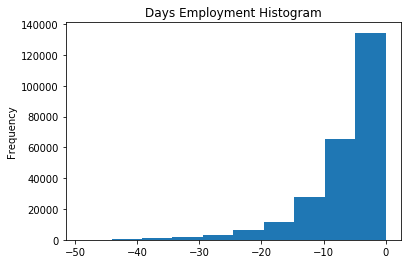

In [65]:

(master_df['DAYS_EMPLOYED'] /365 ).plot.hist(title = 'Days Employment Histogram');

show the distribution of default by DAYS_EMPLOYED

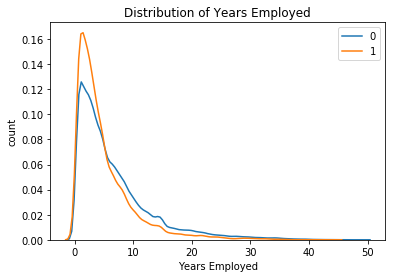

In [70]:

temp['DAYS_EMPLOYED'] = master_df['DAYS_EMPLOYED'] / -365

show_distribution_by_col_value(df=temp, src_col='TARGET', 
                               dest_col='DAYS_EMPLOYED', 
                               title='Distribution of Years Employed', 
                               x_lable='Years Employed', 
                               y_label='count')

as we suspected - people that defaulted tend to work less

## encoding data


There are 16 clumns that are string based and therefore they must be categorical data
for columns that have only two options we will use label incoding, if the columns have more then two options we will use one hot encoding

configure one hot and label encoding using LabelEncoder nad get_dummies

In [71]:

le = LabelEncoder()

for column in master_df.select_dtypes('object'):
    if len(list(master_df[column].unique())) == 2:
        le.fit(master_df[column])
        master_df[column] = le.transform(master_df[column])

#set the rest with one hot
master_df = pd.get_dummies(master_df)


we can see that we dont have categorical data anymore

In [72]:

master_df.dtypes.value_counts()


uint8      134
float64     66
int64       43
bool         1
dtype: int64

early on we saw that many columns has negative values, lets get a list of all columns


In [74]:
for col in master_df.columns:
    values = (master_df[col].dropna() <= 0).value_counts()
    if (len(values) == 1 and values.index[0]):
        print(col)
    

DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE


lets change the the negative values 

In [75]:
#lets change the the negative values 
master_df['DAYS_EMPLOYED'] = abs(master_df['DAYS_EMPLOYED'])
master_df['DAYS_REGISTRATION'] = abs(master_df['DAYS_REGISTRATION'])
master_df['DAYS_ID_PUBLISH'] = abs(master_df['DAYS_ID_PUBLISH'])
master_df['DAYS_LAST_PHONE_CHANGE'] = abs(master_df['DAYS_LAST_PHONE_CHANGE'])



## Missing Values


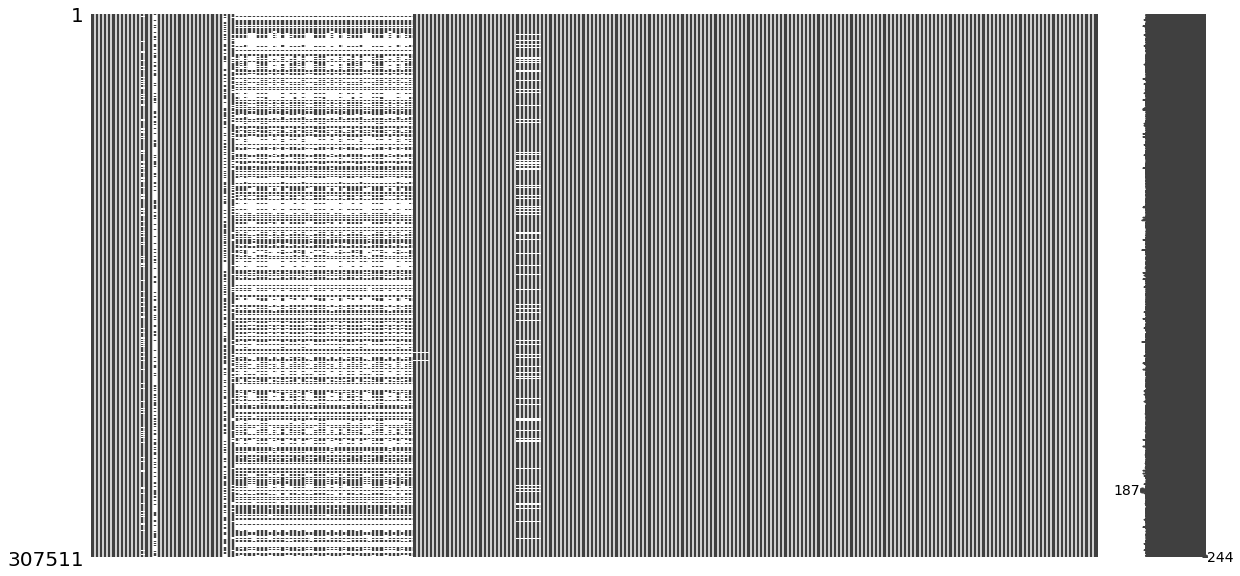

In [76]:
msno.matrix(master_df, inline=True, sparkline=True, figsize=(20,10), sort=None)

generate missing columns table

In [77]:
missing_columns = missing_values_table(master_df)

Your selected dataframe has 244 columns.
There are 62 columns that have missing values.


In [78]:
missing_columns

,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_MODE,208642,67.8


create a portion of that dataset that is not having any NA's for checking correlation

In [80]:
full_df = master_df[master_df.columns.difference(missing_columns.index.tolist())]

lets check the correlations of of missing columns to the actual data

In [81]:
for col in missing_columns.index.tolist(): 
    missing_values = validate_missing_value(full_df, master_df, col)
    missing_rows = (master_df[master_df[col].isna()])['TARGET']
    if len(missing_rows.value_counts()) == 1:
        if missing_rows.values[0] == 0:
            default_row_count = 0
        else:
            default_row_count = missing_rows.value_counts()[0]
    else:
        default_row_count = missing_rows.value_counts()[1]
    default_percent = (default_row_count / len(missing_rows)) *100
    print('{} pvalues percent: {} missing rows {} missing rows defaulted {} default percent {}'.format(col, round(missing_values), len(missing_rows), default_row_count, round(default_percent)))
    

COMMONAREA_MODE pvalues percent: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
COMMONAREA_AVG pvalues percent: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
COMMONAREA_MEDI pvalues percent: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
NONLIVINGAPARTMENTS_MEDI pvalues percent: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
NONLIVINGAPARTMENTS_AVG pvalues percent: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
NONLIVINGAPARTMENTS_MODE pvalues percent: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
LIVINGAPARTMENTS_MODE pvalues percent: 44.0 missing rows 210199 missing rows defaulted 18122 default percent 9.0
LIVINGAPARTMENTS_MEDI pvalues percent: 44.0 missing rows 210199 missing rows defaulted 18122 default percent 9.0
LIVINGAPARTMENTS_AVG pvalues percent: 44.0 missing rows 210199 missing rows defaulted 18122 default percent

All of the columns above show strong realtion to the data. after debating about we decided to cutoff all the rows below 1021
and do a quartile encoding on the rest

Quartile encoding to columns that have above 1021 rows

In [83]:
for col in missing_columns.index:
    if col in missing_columns[(missing_columns['Missing Values'] > 1021)].index.tolist():
        encode_quartile(master_df, col)


Delete all the rows that below 1021 of data

In [84]:
print(str(len(master_df)))
master_df.dropna(subset=
                 (missing_columns['Missing Values'] <= 1021).keys().tolist()
                 , inplace=True)
print(str(len(master_df)))

307511
305545


Do one hot encoding for the data

In [85]:
master_df = pd.get_dummies(master_df)

do we have missing values?

In [86]:
missing_values_table(master_df)

Your selected dataframe has 354 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


cool

## Flet file Saving

In [90]:
master_df.to_csv('../data/flat_file.zip', compression='zip')

## Feature Importance

In [195]:
prog_df = pd.read_csv('../data/flat_file.zip', compression='zip')
#drop unwanted columns
prog_df.drop(columns=['Unnamed: 0'], inplace=True)

In [92]:
prog_df.shape

(305545, 354)

Devide to basic train/test

In [199]:
y = prog_df['TARGET']

In [200]:
X = prog_df.drop(columns=['TARGET', 'SK_ID_CURR'])

Run feature_importance_table function thats uses 3 models (Lasso, Random forest, Xgboot) and decide who are the best features

In [95]:
coaf_df, xgb_reg, lasso_reg, rnd_reg, feature_list = feature_importance_table(X, y, 2);

running Lasso
running RF
running GXB


Here are the selected features

In [96]:
feature_list

['DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR_Q4',
 'NAME_INCOME_TYPE_Working',
 'EXT_SOURCE_1_NA',
 'DAYS_EMPLOYED_Q2',
 'ORGANIZATION_TYPE_Self-employed',
 'OCCUPATION_TYPE_Laborers',
 'NAME_FAMILY_STATUS_Married',
 'DAYS_EMPLOYED_Q1',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_YEAR_Q1',
 'HOUR_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_POPULATION_RELATIVE',
 'AMT_REQ_CREDIT_BUREAU_YEAR_Q3',
 'FLAG_WORK_PHONE',
 'CNT_CHILDREN',
 'AMT_REQ_CREDIT_BUREAU_YEAR_Q2']

In [97]:
len(feature_list)

30

## Model  Selection

split the data using train_test_split

As we noticed before the data is unbalanced so we will take it into considoration

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.20)

In [99]:
print(len(y_train[y_train == 1]) / len(y_train))
print(len(y_test[y_test == 1]) / len(y_test))

0.08089233991719715
0.08088824886677903


Select the apropreate lables from train/test dataset

In [202]:
X_train = X_train[feature_list]
X_test = X_test[feature_list]

#### Testing with xgboost

XGboost supports unbalanced data using scale_pos_weight, lets check what is the recomanded values

In [106]:
scale_pos_weight = math.floor((y_test == 0).sum() / (y_test == 1).sum())

In [107]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 1, learning_rate = 0.001, max_depth = 6, n_estimators = 1000, scale_pos_weight=scale_pos_weight)

In [108]:
xg_model = xg_reg.fit(X=X_train, y=y_train)

Run perdication

In [109]:
pred_xgb = xg_model.predict(X_test)

Check prediction

In [111]:
#normilize the data 
pred_xgb = [0 if i <=0.5 else 1 for i in pred_xgb]

fpr, tpr, thrasholds = roc_curve(y_test, pred_xgb, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6342473643685722


Ok, not the best, lets continue

#### Testing LGBMClassifier

In [155]:
lgb_model = LGBMClassifier()

In [156]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Running prediction

In [157]:
lgb_pred = lgb_model.predict(X=X_test)

Testing the model

In [158]:
fpr, tpr, thrasholds = roc_curve(y_test, lgb_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5013449265795579


#### Testing RandomForestClassifier

This will be using regular, under,over and SMOTEENN sampling

1 use unbalanced Data

In [125]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
rfc_predict = rfc_model.predict(X_test)

Check model

In [126]:
fpr, tpr, thrasholds = roc_curve(y_test, rfc_predict, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5029147633951089


2 use RandomUnderSampler

In [132]:
ros_under = RandomUnderSampler(random_state=0)
ros_under.fit(X_train, y_train)
X_resampled, y_resampled = ros_under.fit_sample(X_train, y_train)

In [133]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_resampled, y_resampled)
rfc_predict = rfc_model.predict(X_test)

Check model

In [134]:
fpr, tpr, thrasholds = roc_curve(y_test, rfc_predict, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6027223271261832


3 use RandomOverSampler

In [135]:
ros_over = RandomOverSampler(random_state=0)
ros_over.fit(X_train, y_train)
X_resampled, y_resampled = ros_over.fit_sample(X_train, y_train)

In [136]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_resampled, y_resampled)
rfc_predict = rfc_model.predict(X_test)

Check Model

In [137]:
fpr, tpr, thrasholds = roc_curve(y_test, rfc_predict, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5092257932792198


4 Using SMOTEENN

In [140]:
ros_smoth = SMOTEENN(random_state=0)
ros_smoth.fit(X_train, y_train)
X_resampled, y_resampled = ros_smoth.fit_sample(X_train, y_train)

In [142]:
ros_SMOTEENN = RandomOverSampler(random_state=0)
ros_SMOTEENN.fit(X_train, y_train)
X_resampled, y_resampled = ros_SMOTEENN.fit_sample(X_train, y_train)

In [143]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_resampled, y_resampled)
rfc_predict = rfc_model.predict(X_test)

Check Model

In [146]:
fpr, tpr, thrasholds = roc_curve(y_test, rfc_predict, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5072480264979099


### Model Tuneup

After reading and debaiting we decidd to use LGBMClassifier with patamaters and RandomForestClassifier using under sampler and see who will be the best 

#### LGBMClassifier with parameters

In [267]:
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.001134,
    'num_leaves': 20,
    'max_depth': 50,
    'subsample_for_bin': 340000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.014766,
    'subsample': 1,
    'is_unbalance': True,
    'silent':-1,
    'verbose':-1
}
RANDOM_SEED = 32134
NUM_THREADS = 8
params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}

In [268]:
lgb_model = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
lgb_model.fit(X_train, y_train, eval_metric='auc', verbose=400)
lgb_pred = lgb_model.predict(X=X_test, num_iteration=lgb_model.best_iteration_)

In [269]:
fpr, tpr, thrasholds = roc_curve(y_test, lgb_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6520414158576162


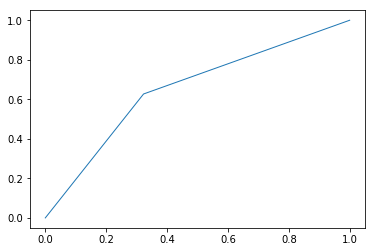

In [270]:
plt.plot(fpr, tpr, lw=1)

#### RandomForestClassifier using under sampler

In [220]:
ros_under = RandomUnderSampler(random_state=0)
ros_under.fit(X_train, y_train)
X_resampled, y_resampled = ros_under.fit_sample(X_train, y_train)

rfc_model = RandomForestClassifier(n_estimators=20, max_depth=2, random_state=737851)
rfc_model.fit(X_resampled, y_resampled)
rfc_predict = rfc_model.predict(X_test)

In [221]:
fpr, tpr, thrasholds = roc_curve(y_test, rfc_predict, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6185731345817195


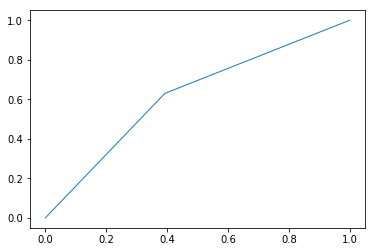

In [225]:
plt.plot(fpr, tpr, lw=1)

## Conclusion

after many changes to the hyper parameters, our selected model is the LGBMClassifier